<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EA%B8%B0%EA%B3%84%EA%B3%A0%EC%9E%A5%EC%A7%84%EB%8B%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 월간 데이콘 기계 고장 진단 AI 경진대회

### case1

https://dacon.io/competitions/official/236036/codeshare/7480?page=1&dtype=recent

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import time
import librosa
import librosa.display
import IPython.display as ipd
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch import optim

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

import pickle
from sklearn.model_selection import train_test_split

<ipython-input-1-e11d70f7058b>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
file_path = "/content/drive/MyDrive/fan_data/"
drive = '/content/drive/MyDrive/fan_data/'

Mounted at /content/drive/


In [ ]:
CFG = {
    'SR':16000
}

Config = {
    "num_epochs" : 100,
    "batch_size" : 64,
    "learning_rate" : 0.0001
}

####################################################

class CWRU(Dataset):
    def __init__(self, data):
        self.x = data

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        return x

    def __len__(self):
        return len(self.x)

####################################################

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(8000, 4000, bias=False)
        self.fc2 = nn.Linear(4000, 2000, bias=False)
        self.fc3 = nn.Linear(2000, 1000, bias=False)
        self.fc4 = nn.Linear(1000, 200, bias=True)

        self.defc1 = nn.Linear(200, 1000, bias=True)
        self.defc2 = nn.Linear(1000, 2000, bias=False)
        self.defc3 = nn.Linear(2000, 4000, bias=False)
        self.defc4 = nn.Linear(4000, 8000, bias=False)

    def encoder(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

    def decoder(self, x):
        x = self.defc1(x)
        x = self.defc2(x)
        x = self.defc3(x)
        x = self.defc4(x)
        return x

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

####################################################

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

####################################################

loss_func = nn.L1Loss()

def train(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    len_data = len(train_loader.dataset)

    for x in train_loader:

        x_hat, _ = model(x)
        loss = loss_func(x, x_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss/len_data

####################################################

def eval(model, dataloader):
  scores=[]
  model.eval()
  print("Testing...")
  with torch.no_grad():
    for x in dataloader:
      x_hat, z=model(x)
      score=torch.mean(torch.abs(x-x_hat), axis=1)
      scores.extend(score.numpy())
  return np.array(scores), z

####################################################

def get_pred_label(model_pred, t):
    model_pred = np.where(model_pred <= t, 0, model_pred) #0:정상
    model_pred = np.where(model_pred > t, 1, model_pred)  #1:불량
    return model_pred


In [ ]:
def all(train_pkl, test_pkl):

    X_train=pd.read_pickle(os.path.join(drive, train_pkl))
    X_test=pd.read_pickle(os.path.join(drive, test_pkl))

    #Train, Valid=train_test_split(X_train, test_size=0.2, random_state=0)

    #print(X_train.shape, '=>', Train.shape, Valid.shape)
    print(X_train.shape)
    print(X_test.shape)
    print()

    #train_dataset=CWRU(Train)
    #valid_dataset=CWRU(Valid)
    train_dataset=CWRU(X_train)
    test_dataset=CWRU(X_test)

    train_loader = DataLoader(dataset=train_dataset, batch_size=Config['batch_size'], shuffle=True)
    #valid_loader = DataLoader(dataset=valid_dataset, batch_size=Config['batch_size'], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=Config['batch_size'], shuffle=False)

    model=AutoEncoder()
    loss_func = nn.L1Loss()
    opt = optim.Adam(model.parameters(), lr=Config['learning_rate'])
    summary(model, [(1,8000)])

    loss_history = {'train': []}
    start_time = time.time()

    for epoch in range(Config['num_epochs']):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, Config['num_epochs'], current_lr))
        train_loss = train(model, train_loader, opt)
        loss_history['train'].append(train_loss)
        print('train loss: %.6f, time: %.4f min' %(train_loss, (time.time()-start_time)/60))
        print('-'*10)

    with torch.no_grad():
      for j,x in enumerate(train_loader):
        opt.zero_grad()
        output, z = model.forward(x)
        break

    scores, z = eval(model, train_loader)
    t=scores.max()
    print(t)

    scores_, z_ = eval(model, test_loader)

    print(scores)
    print(scores_)

    plt.style.use('default')
    plt.rcParams['font.size'] = 12
    plt.hist(scores, bins=50, density=True, alpha=0.7, label='Train data')
    plt.hist(scores_, bins=50, density=True, alpha=0.7, label='Test data')
    plt.axvline(x=t, c='red', linestyle=':', label='Threshold')
    plt.title("Anomaly score")
    plt.legend()

    train_pred = get_pred_label(scores, t)
    print(Counter(train_pred))
    test_pred = get_pred_label(scores_, t)
    print(Counter(test_pred))

    print(train_pred)
    print(test_pred)

    return model, scores_, test_pred

(639, 8000) => (511, 8000) (128, 8000)
(1514, 8000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4000]      32,000,000
            Linear-2              [-1, 1, 2000]       8,000,000
            Linear-3              [-1, 1, 1000]       2,000,000
            Linear-4               [-1, 1, 200]         200,200
            Linear-5              [-1, 1, 1000]         201,000
            Linear-6              [-1, 1, 2000]       2,000,000
            Linear-7              [-1, 1, 4000]       8,000,000
            Linear-8              [-1, 1, 8000]      32,000,000
Total params: 84,401,200
Trainable params: 84,401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.17
Params size (MB): 321.97
Estimated Total Size (MB): 322.16
--------------------------------------------

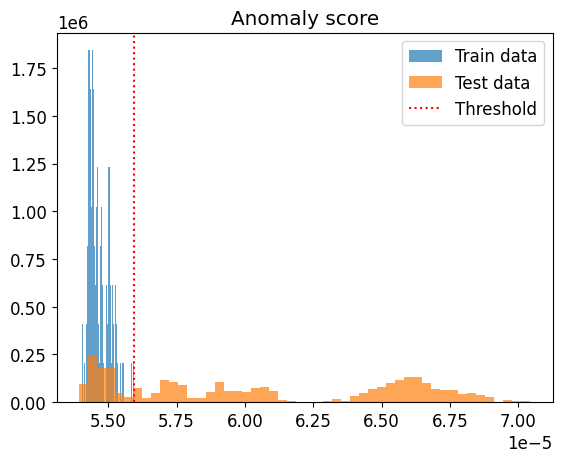

In [ ]:
A=all('fan_train0.pkl', 'fan_test.pkl')

(639, 8000)
(1514, 8000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4000]      32,000,000
            Linear-2              [-1, 1, 2000]       8,000,000
            Linear-3              [-1, 1, 1000]       2,000,000
            Linear-4               [-1, 1, 200]         200,200
            Linear-5              [-1, 1, 1000]         201,000
            Linear-6              [-1, 1, 2000]       2,000,000
            Linear-7              [-1, 1, 4000]       8,000,000
            Linear-8              [-1, 1, 8000]      32,000,000
Total params: 84,401,200
Trainable params: 84,401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.17
Params size (MB): 321.97
Estimated Total Size (MB): 322.16
----------------------------------------------------------------
Epoch 

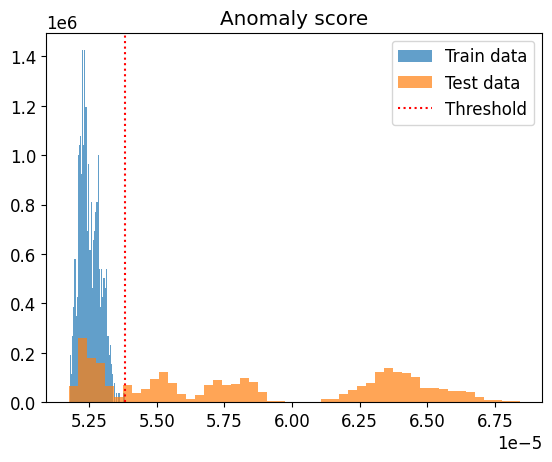

In [ ]:
model0, test_pred=all('fan_train0.pkl', 'fan_test.pkl')

In [ ]:
([0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).count(0)

376

In [ ]:
([0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]).count(1)

762

(639, 8000)
(1514, 8000)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4000]      32,000,000
            Linear-2              [-1, 1, 2000]       8,000,000
            Linear-3              [-1, 1, 1000]       2,000,000
            Linear-4               [-1, 1, 200]         200,200
            Linear-5              [-1, 1, 1000]         201,000
            Linear-6              [-1, 1, 2000]       2,000,000
            Linear-7              [-1, 1, 4000]       8,000,000
            Linear-8              [-1, 1, 8000]      32,000,000
Total params: 84,401,200
Trainable params: 84,401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.17
Params size (MB): 321.97
Estimated Total Size (MB): 322.16
----------------------------------------------------------------
Epoch 

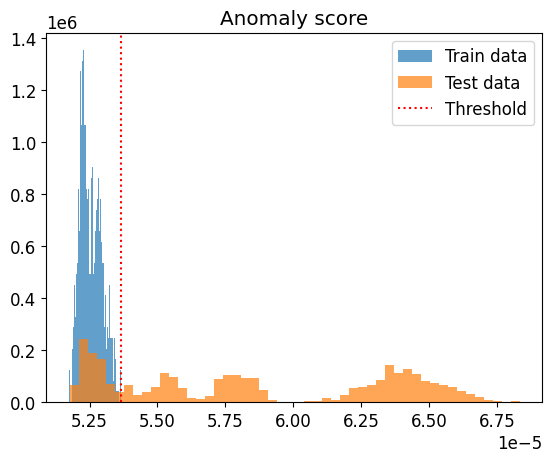

In [ ]:
model2, scores_, test_pred=all('fan_train2.pkl', 'fan_test.pkl')

In [ ]:
submit = pd.read_csv(drive+'./sample_submission.csv')
submit['LABEL0'] = test_pred
submit.to_csv(drive+'./submit.csv', index=False)

In [ ]:
print([i for i in scores_])
print([i for i in test_pred])

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,

In [ ]:
submit

,SAMPLE_ID,LABEL,LABEL0
0,TEST_0000,0,1.0
1,TEST_0001,0,1.0
2,TEST_0002,0,1.0
3,TEST_0003,0,1.0
4,TEST_0004,0,1.0
...,...,...,...
1509,TEST_1509,0,1.0
1510,TEST_1510,0,1.0
1511,TEST_1511,0,0.0
1512,TEST_1512,0,0.0


데이터 불러오기

In [ ]:
train_df = pd.read_csv(file_path +'train.csv')
test_df = pd.read_csv(file_path +'test.csv')
print(train_df['FAN_TYPE'].value_counts())
print("-"*50)
print(train_df['LABEL'].value_counts()) #모두 정상

2    640
0    639
Name: FAN_TYPE, dtype: int64
--------------------------------------------------
0    1279
Name: LABEL, dtype: int64


In [ ]:
def PositiveFFT(Input_rawdata,Sampling_frequency=16000, Length=16000):

    Fs = Sampling_frequency;            # Sampling frequency
    Input_rawdata = np.hanning(Length)*Input_rawdata
    L = len(Input_rawdata);             # Length of si}gnal
    X = Input_rawdata
    Y = np.fft.fft(X)

    N = int(len(Y)/2)
    Y =2*np.abs(Y[0:N])/(L/2)

    freq = np.linspace(0, Fs/2, N, endpoint=True)

    return (Y,freq)

In [ ]:
def FFT_Result(Data):

    STRIDE=16000
    Fs=16000

    sample = [Data[i:i+Fs] for i in range(0, len(Data), STRIDE)]

    F=[]
    A=[]
    for samp in sample:
        y, freq = PositiveFFT(samp)
        A.append(y)

    F=freq
    A=np.array(A).mean(axis=0)

    return F, A

In [ ]:
def get_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH'][1:4]):
        wav, sr = librosa.load(file_path +path[8:], sr=CFG['SR'])
        print(path)
        f, y = FFT_Result(wav)
        features.append(y)
    return np.array(features)

In [ ]:
wav, sr = librosa.load(file_path+'TRAIN_0001.wav', sr=CFG['SR'])
print(wav)
print(wav.shape)

[ 0.00063185  0.00046935 -0.00016419 ...  0.          0.
  0.        ]
(160000,)


In [ ]:
f, y = FFT_Result(wav)
print(f)
print(f.shape)

[0.00000000e+00 1.00012502e+00 2.00025003e+00 ... 7.99799975e+03
 7.99899987e+03 8.00000000e+03]
(8000,)


In [ ]:
X_train.shape

(3, 8000)

In [ ]:
X_train[0]

array([2.45731976e-06, 4.78431902e-06, 9.86272326e-06, ...,
       9.61796915e-11, 9.54006421e-11, 1.08009007e-10])

In [ ]:
train_df['SAMPLE_PATH']

0       ./train/TRAIN_0000.wav
1       ./train/TRAIN_0001.wav
2       ./train/TRAIN_0002.wav
3       ./train/TRAIN_0003.wav
4       ./train/TRAIN_0004.wav
                 ...          
1274    ./train/TRAIN_1274.wav
1275    ./train/TRAIN_1275.wav
1276    ./train/TRAIN_1276.wav
1277    ./train/TRAIN_1277.wav
1278    ./train/TRAIN_1278.wav
Name: SAMPLE_PATH, Length: 1279, dtype: object

In [ ]:
X_train=pd.read_pickle(os.path.join(drive, 'fan_train.pkl'))
X_test=pd.read_pickle(os.path.join(drive, 'fan_test.pkl'))

In [ ]:
###
X_train0=pd.read_pickle(os.path.join(drive, 'fan_train0.pkl'))
X_train2=pd.read_pickle(os.path.join(drive, 'fan_train2.pkl'))
X_test=pd.read_pickle(os.path.join(drive, 'fan_test.pkl'))

In [ ]:
###
print(X_train0.shape)
print(X_train2.shape)
print(X_test.shape)

(639, 8000)
(640, 8000)
(1514, 8000)


In [ ]:
###
from sklearn.model_selection import train_test_split
train0, valid0=train_test_split(X_train0, test_size=0.2, random_state=0)

In [ ]:
###
print(train0.shape)
print(valid0.shape)

(511, 8000)
(128, 8000)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(1279, 8000)
(1514, 8000)


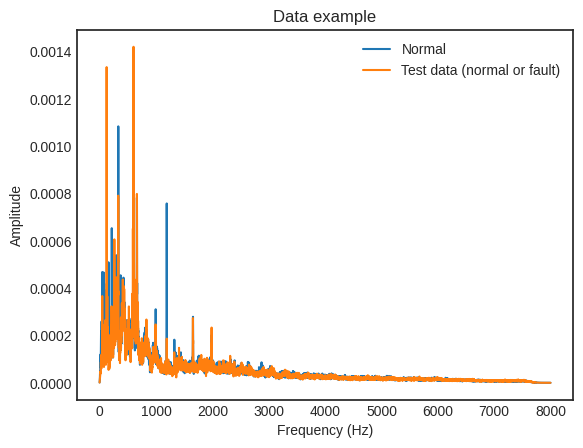

In [ ]:
ind = 0
plt.plot(np.arange(len(X_train[0])), X_train[ind], label='Normal')
plt.plot(np.arange(len(X_test[0])), X_test[ind], label='Test data (normal or fault)')
plt.title("Data example")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()

In [ ]:
CFG = {
    'SR':16000
}

Config = {
    "num_epochs" : 100,
    "batch_size" : 64,
    "learning_rate" : 0.0001
}

In [ ]:
class CWRU(Dataset):
    def __init__(self, data):

        self.x = data

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])

        return x

    def __len__(self):
        return len(self.x)

In [ ]:
train_dataset=CWRU(X_train)
test_dataset=CWRU(X_test)

In [ ]:
###
train_dataset0=CWRU(X_train0)
train_dataset2=CWRU(X_train2)
test_dataset=CWRU(X_test)

In [ ]:
###
train_loader0 = DataLoader(dataset=train_dataset0, batch_size=Config['batch_size'], shuffle=True)
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=Config['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=Config['batch_size'], shuffle=False)

In [ ]:
###
train_dataset0=CWRU(train0)
valid_dataset0=CWRU(valid0)
test_dataset=CWRU(X_test)

In [ ]:
###
train_loader0 = DataLoader(dataset=train_dataset0, batch_size=Config['batch_size'], shuffle=True)
valid_loader0 = DataLoader(dataset=valid_dataset0, batch_size=Config['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=Config['batch_size'], shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.fc1 = nn.Linear(8000, 4000, bias=False)
        self.fc2 = nn.Linear(4000, 2000, bias=False)
        self.fc3 = nn.Linear(2000, 1000, bias=False)
        self.fc4 = nn.Linear(1000, 200, bias=True)

        self.defc1 = nn.Linear(200, 1000, bias=True)
        self.defc2 = nn.Linear(1000, 2000, bias=False)
        self.defc3 = nn.Linear(2000, 4000, bias=False)
        self.defc4 = nn.Linear(4000, 8000, bias=False)


    def encoder(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

    def decoder(self, x):
        x = self.defc1(x)
        x = self.defc2(x)
        x = self.defc3(x)
        x = self.defc4(x)

        return x

    def forward(self, x):

        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
model = AutoEncoder()
loss_func = nn.L1Loss()
opt = optim.Adam(model.parameters(), lr=Config['learning_rate'])

summary(model, [(1,8000)] )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4000]      32,000,000
            Linear-2              [-1, 1, 2000]       8,000,000
            Linear-3              [-1, 1, 1000]       2,000,000
            Linear-4               [-1, 1, 200]         200,200
            Linear-5              [-1, 1, 1000]         201,000
            Linear-6              [-1, 1, 2000]       2,000,000
            Linear-7              [-1, 1, 4000]       8,000,000
            Linear-8              [-1, 1, 8000]      32,000,000
Total params: 84,401,200
Trainable params: 84,401,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.17
Params size (MB): 321.97
Estimated Total Size (MB): 322.16
----------------------------------------------------------------


In [ ]:
###
model0 = AutoEncoder()
model2 = AutoEncoder()

loss_func = nn.L1Loss()
opt0 = optim.Adam(model0.parameters(), lr=Config['learning_rate'])
opt2 = optim.Adam(model2.parameters(), lr=Config['learning_rate'])

In [ ]:
def train(model, train_loader, optimizer):

    model.train()

    running_loss = 0.0
    len_data = len(train_loader.dataset)

    for x in train_loader:

        x_hat, _ = model(x)
        loss = loss_func(x, x_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss/len_data

In [ ]:
### valid
loss_history = {'train': []}
start_time = time.time()

for epoch in range(Config['num_epochs']):

    current_lr = get_lr(opt0)
    print('Epoch {}/{}, current lr={}'.format(epoch+1, Config['num_epochs'], current_lr))

    train_loss = train(model0, train_loader0, opt0)
    loss_history['train'].append(train_loss)
#     plt.plot(np.arange(len(loss_history['train'])), loss_history['train'])
#     plt.show()
    print('train loss: %.6f, time: %.4f min' %(train_loss, (time.time()-start_time)/60))
    print('-'*10)

Epoch 1/100, current lr=0.0001
train loss: 0.000001, time: 0.2281 min
----------
Epoch 2/100, current lr=0.0001
train loss: 0.000001, time: 0.4330 min
----------
Epoch 3/100, current lr=0.0001
train loss: 0.000001, time: 0.6294 min
----------
Epoch 4/100, current lr=0.0001
train loss: 0.000001, time: 0.8445 min
----------
Epoch 5/100, current lr=0.0001
train loss: 0.000001, time: 1.0541 min
----------
Epoch 6/100, current lr=0.0001
train loss: 0.000001, time: 1.2482 min
----------
Epoch 7/100, current lr=0.0001
train loss: 0.000001, time: 1.4980 min
----------
Epoch 8/100, current lr=0.0001
train loss: 0.000001, time: 1.6813 min
----------
Epoch 9/100, current lr=0.0001
train loss: 0.000001, time: 1.8764 min
----------
Epoch 10/100, current lr=0.0001
train loss: 0.000001, time: 2.0704 min
----------
Epoch 11/100, current lr=0.0001
train loss: 0.000001, time: 2.2933 min
----------
Epoch 12/100, current lr=0.0001
train loss: 0.000001, time: 2.6028 min
----------
Epoch 13/100, current lr=

In [ ]:
###
loss_history = {'train': []}
start_time = time.time()

for epoch in range(Config['num_epochs']):

    current_lr = get_lr(opt0)
    print('Epoch {}/{}, current lr={}'.format(epoch+1, Config['num_epochs'], current_lr))

    train_loss = train(model0, train_loader0, opt0)
    loss_history['train'].append(train_loss)
#     plt.plot(np.arange(len(loss_history['train'])), loss_history['train'])
#     plt.show()
    print('train loss: %.6f, time: %.4f min' %(train_loss, (time.time()-start_time)/60))
    print('-'*10)

Epoch 1/100, current lr=0.0001
train loss: 0.000002, time: 0.2484 min
----------
Epoch 2/100, current lr=0.0001
train loss: 0.000002, time: 0.5088 min
----------
Epoch 3/100, current lr=0.0001
train loss: 0.000002, time: 0.7636 min
----------
Epoch 4/100, current lr=0.0001
train loss: 0.000001, time: 1.0104 min
----------
Epoch 5/100, current lr=0.0001
train loss: 0.000001, time: 1.2479 min
----------
Epoch 6/100, current lr=0.0001
train loss: 0.000001, time: 1.4804 min
----------
Epoch 7/100, current lr=0.0001
train loss: 0.000001, time: 1.7120 min
----------
Epoch 8/100, current lr=0.0001
train loss: 0.000001, time: 1.9428 min
----------
Epoch 9/100, current lr=0.0001
train loss: 0.000001, time: 2.1751 min
----------
Epoch 10/100, current lr=0.0001
train loss: 0.000001, time: 2.4389 min
----------
Epoch 11/100, current lr=0.0001
train loss: 0.000001, time: 2.6727 min
----------
Epoch 12/100, current lr=0.0001
train loss: 0.000001, time: 2.9045 min
----------
Epoch 13/100, current lr=

In [ ]:
loss_history = {'train': []}
start_time = time.time()

for epoch in range(Config['num_epochs']):

    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch+1, Config['num_epochs'], current_lr))

    train_loss = train(model, train_loader, opt)
    loss_history['train'].append(train_loss)
#     plt.plot(np.arange(len(loss_history['train'])), loss_history['train'])
#     plt.show()
    print('train loss: %.6f, time: %.4f min' %(train_loss, (time.time()-start_time)/60))
    print('-'*10)

Epoch 1/100, current lr=0.0001
train loss: 0.000016, time: 0.5374 min
----------
Epoch 2/100, current lr=0.0001
train loss: 0.000002, time: 1.2837 min
----------
Epoch 3/100, current lr=0.0001
train loss: 0.000002, time: 2.0555 min
----------
Epoch 4/100, current lr=0.0001
train loss: 0.000001, time: 2.6286 min
----------
Epoch 5/100, current lr=0.0001
train loss: 0.000001, time: 3.3529 min
----------
Epoch 6/100, current lr=0.0001
train loss: 0.000001, time: 3.9088 min
----------
Epoch 7/100, current lr=0.0001
train loss: 0.000001, time: 4.4111 min
----------
Epoch 8/100, current lr=0.0001
train loss: 0.000001, time: 4.9158 min
----------
Epoch 9/100, current lr=0.0001
train loss: 0.000001, time: 5.4429 min
----------
Epoch 10/100, current lr=0.0001
train loss: 0.000001, time: 6.0469 min
----------
Epoch 11/100, current lr=0.0001
train loss: 0.000001, time: 6.5560 min
----------
Epoch 12/100, current lr=0.0001
train loss: 0.000001, time: 7.0754 min
----------
Epoch 13/100, current lr=

In [ ]:
###
with torch.no_grad():

    for j,x in enumerate(train_loader0):
        opt0.zero_grad()
        output, z = model0.forward(x)
        break

In [ ]:
def eval(model, dataloader):

  scores=[]
  model.eval()
  print("Testing...")
  with torch.no_grad():
    for x in dataloader:
      x_hat, z=model(x)
      score=torch.mean(torch.abs(x-x_hat), axis=1)
      scores.extend(score.numpy())

  return np.array(scores), z

In [ ]:
###
scores, z = eval(model0, valid_loader0)
t=scores.max()
print(scores.shape)

Testing...
(128,)


In [ ]:
###
scores, z = eval(model0, train_loader0)
t=scores.max()
print(scores.shape)

Testing...
(639,)


In [ ]:
scores_, z_ = eval(model0, test_loader)

Testing...


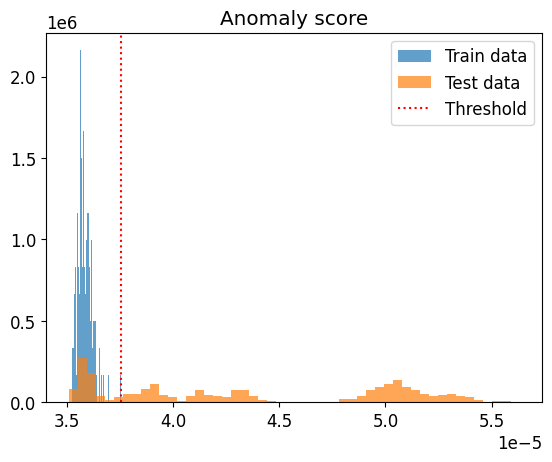

In [ ]:
plt.style.use('default')
plt.rcParams['font.size'] = 12

plt.hist(scores, bins=50, density=True, alpha=0.7, label='Train data')
plt.hist(scores_, bins=50, density=True, alpha=0.7, label='Test data')
plt.axvline(x=t, c='red', linestyle=':', label='Threshold')
plt.title("Anomaly score")
plt.legend()

In [ ]:
def get_pred_label(model_pred, t):
    # (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= t, 0, model_pred)
    model_pred = np.where(model_pred > t, 1, model_pred)
    return model_pred

In [ ]:
train_pred = get_pred_label(scores, t)
Counter(train_pred)

Counter({0.0: 639})

In [ ]:
###
train_pred = get_pred_label(scores, t)
Counter(train_pred)

Counter({0.0: 128})

In [ ]:
test_pred = get_pred_label(scores_, t)
Counter(test_pred)

Counter({0.0: 761, 1.0: 753})

In [ ]:
###
test_pred = get_pred_label(scores_, t)
Counter(test_pred)

Counter({1.0: 1134, 0.0: 380})

In [ ]:
###
test_pred = get_pred_label(scores_, t)
Counter(test_pred)

Counter({1.0: 1122, 0.0: 392})

In [ ]:
x=['a','b','c']
y=['d','e']
print(x.append(y))
print(x.extend(y))

### case2

https://dacon.io/competitions/official/236036/codeshare/7446?page=1&dtype=recent

sound task에서 input data로 mel spectrogram나 mfcc를 많이 사용

type2 모델링은 둘 다

type0는 전자만 사용 (mfcc는 성능이 좋지 않아서)

tsne를 통해 type에 따른 데이터 분포의 차이를 확인

mel-spectrogram: 연산량이 많지만, 특정 도메인의 학습 데이터로 적합

mfcc: 연산량이 적고, 일반적인 학습 데이터로 적합 (한정X)

In [ ]:
from sklearn.manifold import TSNE

train_all = pd.read_pickle(os.path.join(drive, 'fan_train.pkl'))
test_all = pd.read_pickle(os.path.join(drive, 'fan_test.pkl'))

In [ ]:
pd.read_csv(drive+'train.csv').head()

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0


In [ ]:
train_fan = pd.read_csv(drive+ 'train.csv').iloc[:,2]
test_fan = pd.read_csv(drive+ 'test.csv').iloc[:,2]

### Trainset의 분포

In [ ]:
from glob import glob
train_path = glob(drive+'/*')

In [ ]:
train_path

['/content/drive/MyDrive/fan_data/TEST_0001.wav',
 '/content/drive/MyDrive/fan_data/TEST_0002.wav',
 '/content/drive/MyDrive/fan_data/TEST_0003.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0001.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0003.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0002.wav',
 '/content/drive/MyDrive/fan_data/test.csv',
 '/content/drive/MyDrive/fan_data/sample_submission.csv',
 '/content/drive/MyDrive/fan_data/train.csv',
 '/content/drive/MyDrive/fan_data/fan_test2.pkl',
 '/content/drive/MyDrive/fan_data/fan_train0.pkl',
 '/content/drive/MyDrive/fan_data/fan_test0.pkl',
 '/content/drive/MyDrive/fan_data/fan_test.pkl',
 '/content/drive/MyDrive/fan_data/fan_train.pkl',
 '/content/drive/MyDrive/fan_data/fan_train2.pkl']

<Axes: xlabel='com1', ylabel='com2'>

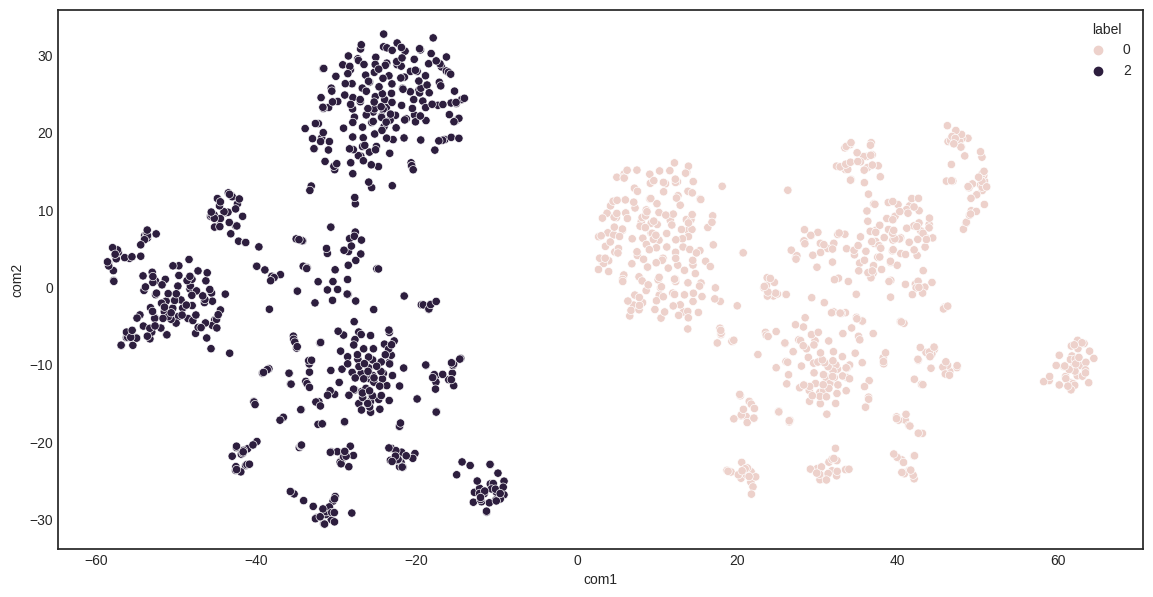

In [ ]:
np.random.seed(160)

tsne = TSNE(n_components=2) #2차원으로 축소하는 모델
tt = tsne.fit_transform(train_all) #학습

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train_fan

sns.set_palette('deep')
plt.figure(figsize=(14,7))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

In [ ]:
tt      #이미지를 받아서 2차원으로 축소하였므로, 2차언 좌표값이 출력됩니다

array([[-48.29124   ,  -0.24242218],
       [ 34.202652  ,  13.892441  ],
       [ 32.636963  ,   1.1495789 ],
       ...,
       [-15.007776  , -24.22973   ],
       [-32.0432    , -29.65345   ],
       [ 30.119913  ,  -5.833503  ]], dtype=float32)

In [ ]:
print(train_all.shape)
print(tt.shape)

(1279, 8000)
(1279, 2)


In [ ]:
tt_df

,com1,com2,label
0,-48.291241,-0.242422,2
1,34.202652,13.892441,0
2,32.636963,1.149579,0
3,-51.492611,-3.155128,2
4,-24.737753,-14.501212,2
...,...,...,...
1274,-25.322332,-11.719488,2
1275,-31.703262,23.224874,2
1276,-15.007776,-24.229731,2
1277,-32.043201,-29.653450,2


In [ ]:
train0=pd.read_pickle(os.path.join(drive, 'fan_train0.pkl'))
train2=pd.read_pickle(os.path.join(drive, 'fan_train2.pkl'))
test0=pd.read_pickle(os.path.join(drive, 'fan_test0.pkl'))
test2=pd.read_pickle(os.path.join(drive, 'fan_test2.pkl'))

In [ ]:
train_path = glob(drive+'/TRAIN*')
train_path

['/content/drive/MyDrive/fan_data/TRAIN_0001.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0003.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0002.wav']

In [ ]:
def get_feature_mfcc(path):
    features = []
    for i in tqdm(path):
        print(i)
        data, sr = librosa.load(i) #16000
        mfcc = librosa.feature.mfcc(data, sr=sr) # n_mfcc=128
        m_mfcc = mfcc.mean(axis=1)
        features.append(m_mfcc)
    return np.array(features)

In [ ]:
train_fan = pd.read_csv(drive+ 'train.csv')
test_fan = pd.read_csv(drive+ 'test.csv')

In [ ]:
get_feature_mfcc(train_path)

  0%|          | 0/3 [00:00<?, ?it/s]

/content/drive/MyDrive/fan_data/TRAIN_0001.wav


TypeError: ignored

In [ ]:
type(train_fan['SAMPLE_PATH'])

pandas.core.series.Series

In [ ]:
for path in tqdm(train_fan['SAMPLE_PATH']):
  print(path)

  0%|          | 0/1279 [00:00<?, ?it/s]

./train/TRAIN_0000.wav
./train/TRAIN_0001.wav
./train/TRAIN_0002.wav
./train/TRAIN_0003.wav
./train/TRAIN_0004.wav
./train/TRAIN_0005.wav
./train/TRAIN_0006.wav
./train/TRAIN_0007.wav
./train/TRAIN_0008.wav
./train/TRAIN_0009.wav
./train/TRAIN_0010.wav
./train/TRAIN_0011.wav
./train/TRAIN_0012.wav
./train/TRAIN_0013.wav
./train/TRAIN_0014.wav
./train/TRAIN_0015.wav
./train/TRAIN_0016.wav
./train/TRAIN_0017.wav
./train/TRAIN_0018.wav
./train/TRAIN_0019.wav
./train/TRAIN_0020.wav
./train/TRAIN_0021.wav
./train/TRAIN_0022.wav
./train/TRAIN_0023.wav
./train/TRAIN_0024.wav
./train/TRAIN_0025.wav
./train/TRAIN_0026.wav
./train/TRAIN_0027.wav
./train/TRAIN_0028.wav
./train/TRAIN_0029.wav
./train/TRAIN_0030.wav
./train/TRAIN_0031.wav
./train/TRAIN_0032.wav
./train/TRAIN_0033.wav
./train/TRAIN_0034.wav
./train/TRAIN_0035.wav
./train/TRAIN_0036.wav
./train/TRAIN_0037.wav
./train/TRAIN_0038.wav
./train/TRAIN_0039.wav
./train/TRAIN_0040.wav
./train/TRAIN_0041.wav
./train/TRAIN_0042.wav
./train/TRA

In [ ]:
train_f0 = get_feature_mfcc(list(train_path))

  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
list(train_path)

['/content/drive/MyDrive/fan_data/TRAIN_0001.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0003.wav',
 '/content/drive/MyDrive/fan_data/TRAIN_0002.wav']

## case3